In [1]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir, makedirs
from os.path import join, isfile, exists, dirname
import gc
import re
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import TfidfModel, LdaModel, Word2Vec, Doc2Vec, FastText, CoherenceModel

from constants import *
from topic_reranking import TopicsLoader, Reranker
from utils import load

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tqdm_notebook.pandas()
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.precision = 3
pd.options.display.width = 2000

Populating the interactive namespace from numpy and matplotlib


-----

### Loading embeddings

In [2]:
d2v = load('d2v').docvecs
w2v = load('w2v').wv
ftx = load('ftx').wv

# Dry run to make sure both indices are fully in RAM
d2v.init_sims()
vector = d2v.vectors_docs_norm[0]
d2v.index2entity[0]
d2v.most_similar([vector], topn=5)

w2v.init_sims()
vector = w2v.vectors_norm[0]
w2v.index2entity[0]
w2v.most_similar([vector], topn=5)

ftx.init_sims()
vector = ftx.vectors_norm[0]
ftx.index2entity[0]
ftx.most_similar([vector], topn=5)

kvs = {'d2v': d2v, 'w2v': w2v, 'ftx': ftx}

Reading ../data/preprocessed/embeddings/d2v/d2v
Reading ../data/preprocessed/embeddings/w2v/w2v
Reading ../data/preprocessed/embeddings/ftx/ftx


------

### Vector-based reranking

In [3]:
#nb_topics = 1
version = 'noun'
nb_candidate_terms = 20
nb_top_terms = 10

In [20]:
def _rank(df, name):
    df[f'{name}_drank'] = df[f'{name}_dscore'].rank().map(lambda x: x-1)
    df[f'{name}_rrank'] = df[f'{name}_rscore'].rank().map(lambda x: x-1)
    return df

def fillna_max(df):
    mask = df.isnull().any(axis=1)
    df[mask] = df[mask].apply(lambda x: x.fillna(x.max()), axis=1)
    return df

def rerank(topic_param):
    reference = pd.Series(np.arange(nb_candidate_terms), index=topic_param, name='ref_rank')
    scores = [reference]
    for name, kv in kvs.items():
        in_kv = np.vectorize(lambda x: x in kv)
        mask = in_kv(topic_param)
        topic = topic_param[mask]
        not_in_kv = topic_param[~mask]
        nb_terms_in_vocab = len(topic)
        rank_scores = defaultdict(int)
        dist_scores = defaultdict(float)
        for i in range(nb_terms_in_vocab):
            entity = topic[i]
            others = np.delete(topic, i)
            distances = kv.distances(entity, tuple(others))
            argsort = distances.argsort()
            nearest = others[argsort]
            for j, term in zip(distances, others):
                dist_scores[term] += j
            for j, term in enumerate(nearest):
                rank_scores[term] += j
        d_score = pd.Series(dist_scores, name=f'{name}_dscore')
        r_score = pd.Series(rank_scores, name=f'{name}_rscore')
        dr = pd.concat([d_score, r_score], axis=1)
        dr = _rank(dr, name)
        scores.append(dr)
    df = pd.concat(scores, axis=1, sort=False)
    if df.isnull().any().any():
        for s in ['dscore', 'rscore', 'drank', 'rrank']:
            scols = df.columns.str.contains(s)
            df.loc[:, scols] = fillna_max(df.loc[:, scols])
    
    # getting scores and ranks for all combinations -> calculating c = a+b for both distance and rank scores 
    # and getting a rank for the sum
    for c, a, b in [('dw', 'd2v', 'w2v'), ('df', 'd2v', 'ftx'), ('wf', 'w2v', 'ftx'), ('dwf', 'dw', 'ftx')]:
        df[f'{c}_dscore'] = df[f'{a}_dscore'] + df[f'{b}_dscore']
        df[f'{c}_rscore'] = df[f'{a}_rscore'] + df[f'{b}_rscore']
        df = _rank(df, c)

    #print(df)
    return df

def sort_terms(col):
    top_terms = col.sort_values().index.values[:nb_top_terms]
    col = col[col.index.isin(top_terms)]
    return col.index.values

def remove_not_matching_terms(kv_name, topic):
    kv = kvs[kv_name]
    reduced_tpx = topic

    in_kv = np.vectorize(lambda x: x in kv)
    mask = in_kv(topic)
    reduced_tpx = topic[mask]
    not_in_kv = topic[~mask]
    nb_terms_in_kv = len(reduced_tpx)
    if nb_terms_in_kv > nb_top_terms:
        for i in range(nb_terms_in_kv - nb_top_terms):
            remove = kv.doesnt_match(reduced_tpx)
            reduced_tpx = reduced_tpx[reduced_tpx != remove]
    elif nb_terms_in_kv == 0:
        reduced_tpx = topic[:nb_top_terms]
    elif nb_terms_in_kv < nb_top_terms:
        nb_missing = nb_top_terms - nb_terms_in_kv
        for i, m in enumerate(mask):
            if not m:
                mask[i] = True
                nb_missing -= 1
                if nb_missing == 0:
                    break
        reduced_tpx = topic[mask]
        
    ser = pd.Series(reduced_tpx, name=kv_name + '_matches')
    return ser

def vote(df, reference, name='vote'):
    jury = (
        df
        .loc[:, 'term0':f'term{nb_top_terms-1}']
        .apply(pd.value_counts)
        .sum(axis=1)
        [reference]
        .dropna()
        .astype(np.int16)
        .reset_index()
        .rename(columns={'index':'term', 0:'count'})
        .sort_values('count', ascending=False, kind='mergesort')
        [:nb_top_terms]
        .set_index('term')
        .squeeze()
        [reference]
        .dropna()
        .reset_index()
        .rename(lambda x: f'term{x}')
        .drop('count', axis=1)
        .squeeze()
        .rename(name)
    )
    return jury

def calc_oop(col, reference_ranks):
    terms = col.values
    ref_ranks = reference_ranks[terms]
    oop = (ref_ranks - np.arange(len(ref_ranks))).abs().sum()
    return oop

def full_rerank_and_everything(topic):
    topic = topic.values[0]

    df = rerank(topic)
    rank_columns = [col for col in df.columns if 'rank' in col]
    df_ranks = df[rank_columns]
    reranks = df_ranks.apply(sort_terms, axis=0).reset_index(drop=True).T.rename(columns=lambda x: f'term{x}')

    dred = remove_not_matching_terms('d2v', topic)
    wred = remove_not_matching_terms('w2v', topic)
    fred = remove_not_matching_terms('ftx', topic)
    reds = pd.concat([dred, wred, fred], axis=1).T.rename(columns=lambda x: f'term{x}')
    reranks = pd.concat([reranks, reds])

    votes = []
    for name in ['rrank', 'drank', 'matches', '']:
        x = reranks[reranks.index.str.contains(name)]
        v = vote(x, topic, f'{name}_vote'.strip('_'))
        votes.append(v)
    reranks = reranks.append(votes)

    reranks['oop_scores'] = reranks.apply(lambda x: calc_oop(x, df_ranks.ref_rank), axis=1)
    return reranks

def plot_scores(scores):
    sns.set()
    pylab.rcParams['figure.figsize'] = (40, 15)
    scores.boxplot()

In [5]:
def score_and_plot(topics):
    result = topics.groupby(level=[0, 1, 2, 3], sort=False).progress_apply(full_rerank_and_everything)
    result.index = result.index.rename(names='metric', level=-1)
    scores = result.oop_scores.unstack('metric')
    #scores.describe()
    plot_scores(scores)
    return result

param_ids = ['e42']
nbs_topics = [10]#, 25, 50, 100]

topics = []
for dataset in ['O']:#['dewac', 'dewiki', 'dewa1', 'O', 'news', 'speeches', 'FA', 'FO', 'E', 'P']:
    topics_loader = TopicsLoader(
        dataset=dataset,
        param_ids=param_ids,
        nbs_topics=nbs_topics,
        version=version,
        topn=nb_candidate_terms
    )
    topics.append(topics_loader.topics)

topics = pd.concat(topics)

Loading dictionary from ../data/preprocessed/LDAmodel/noun/bow/OnlineParticipation_noun_bow.dict
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/OnlineParticipation_LDAmodel_e42_10_ep30


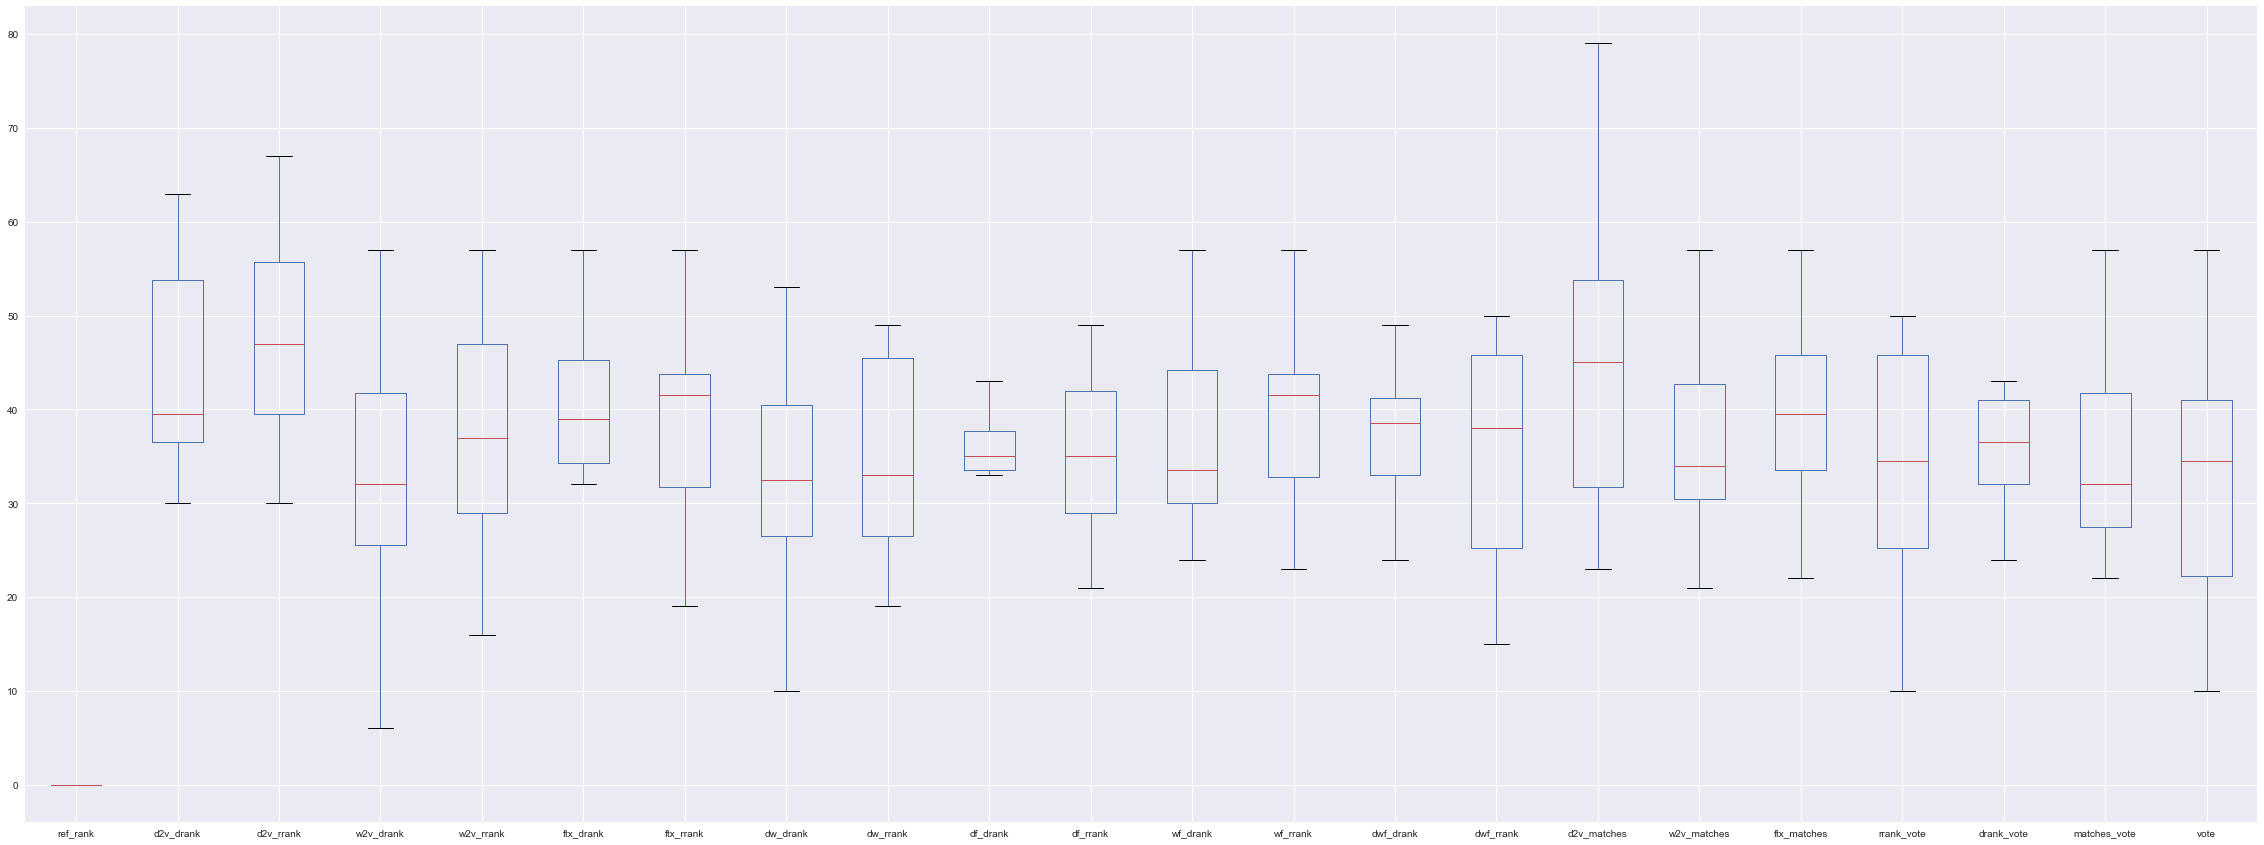

In [64]:
results = score_and_plot(topics)

In [65]:
#results.to_csv(join(TPX_PATH, ))
results

term0           term1               term2               term3          term4          term5           term6          term7           term8           term9  oop_scores
dataset             param_id nb_topics topic_idx metric                                                                                                                                                                                    
OnlineParticipation e42      10        0         ref_rank             Köln            Müll              Mensch               Stadt        Gebäude          Leute            Jahr      Mülleimer         Mülheim           Hotel           0
                                                 d2v_drank            Köln          Mensch               Stadt             Gebäude           Jahr        Wohnung        Geschäft      Sanierung            Porz       Vorschlag          41
                                                 d2v_rrank          Mensch           Stadt             Gebäude               Leute           Jahr        Wohnung        Geschäft      Sanierung            Porz       Vorschlag          46
                                                 w2v_drank           Stadt         Gebäude               Leute             Mülheim          Hotel        Wohnung             Ort         Straße        Geschäft         Tourist          44
                                                 w2v_rrank           Stadt         Gebäude               Leute               Hotel        Wohnung            Ort          Straße       Geschäft         Tourist       Sanierung          51
                                                 ftx_drank           Stadt         Gebäude               Leute                Jahr          Hotel        Wohnung             Ort         Straße        Geschäft       Sanierung          43
                                                 ftx_rrank           Stadt         Gebäude               Leute                Jahr          Hotel        Wohnung             Ort         Straße        Geschäft       Sanierung          43
                                                 dw_drank            Stadt         Gebäude               Leute             Mülheim          Hotel        Wohnung          Straße       Geschäft       Sanierung       Vorschlag          51
                                                 dw_rrank            Stadt         Gebäude               Leute                Jahr          Hotel        Wohnung          Straße       Geschäft       Sanierung       Vorschlag          49
                                                 df_drank            Stadt         Gebäude               Leute                Jahr          Hotel        Wohnung          Straße       Geschäft       Sanierung       Vorschlag          49
                                                 df_rrank            Stadt         Gebäude               Leute                Jahr          Hotel        Wohnung          Straße       Geschäft       Sanierung       Vorschlag          49
                                                 wf_drank            Stadt         Gebäude               Leute             Mülheim          Hotel        Wohnung             Ort         Straße        Geschäft       Sanierung          45
                                                 wf_rrank            Stadt         Gebäude               Leute                Jahr          Hotel        Wohnung             Ort         Straße        Geschäft       Sanierung          43
                                                 dwf_drank          Mensch           Stadt             Gebäude               Leute          Hotel        Wohnung             Ort         Straße        Geschäft       Sanierung          39
                                                 dwf_rrank           Stadt         Gebäude               Leute                Jahr          Hotel        Wohnung          Straße       Geschäft       Sanierung       Vorschlag          49
                                                 d2v_matc

In [13]:
topics

term0    term1           term2               term3        term4          term5       term6       term7        term8          term9         term10    term11              term12         term13          term14        term15                term16          term17         term18     term19
dataset             param_id nb_topics topic_idx                                                                                                                                                                                                                                                                                                  
OnlineParticipation e42      10        0               Köln     Müll          Mensch               Stadt      Gebäude          Leute        Jahr   Mülleimer      Mülheim          Hotel        Wohnung       Ort              Straße       Geschäft         Tourist     Sanierung                  Porz       Vorschlag  Bad_Godesberg    Problem
                                       1               Kind   Schule      Spielplatz         Jugendliche    Vorschlag          Elter        Kita        Jahr     Toilette        Mädchen  Unterstützung    Arbeit             Familie         Mensch            Idee  Kindergarten           Einrichtung           Stadt           Zeit       Geld
                                       2          Vorschlag  Beitrag            Dank           Kategorie  Verständnis     Moderation       Thema  Auswertung        Hallo  Themenbereich           Gruß      Gast  Radverkehrsführung      Kommentar         Hinweis        Wähner  Moderation_Nowzamani  Bürgerhaushalt     Teilnehmer  Sonstiges
                                       3          Radfahrer   Radweg            Auto            Richtung       Straße      Fußgänger  Autofahrer       Ampel     Kreuzung       Fahrbahn         Stelle       Weg               Seite  Fahrradfahrer       Situation    Radverkehr         Fahrradstraße         Fahrrad     Fahrradweg    Verkehr
                                       4              Stadt     Köln            Jahr       Bad_Godesberg       Schule        Projekt         Bad        Geld         Kind        Angebot     Schwimmbad   Bildung              Mensch         Bürger         Schüler       Problem                  Euro          Verein         Kultur       Frau
                                       5                Weg   Radweg  Straßenlaterne  Straßenbeleuchtung  Beleuchtung        Fahrrad      Gehweg      Straße       Stelle         Poller          Woche   Zustand                 Rad   Gehwegplatte  Fahrradständer       Bereich                  Höhe             Tag           Jahr       Haus
                                       6              Stadt     Bonn          Bürger                Geld       Kosten           Jahr   Vorschlag  Verwaltung         Oper           Köln           Euro  Haushalt          Stadt_Köln    Mitarbeiter          Kultur    Stadt_Bonn               Projekt        gut_Idee            Rat  Wuppertal
                                       7              Stadt    Platz            Park          Innenstadt         Hund         Fläche        Baum        Bank  Ordnungsamt     Grünfläche           Köln    Mensch            Anwohner         Bürger        Einnahme        Sommer         Hundebesitzer            Jahr        Bußgeld      Markt
                                       8          Vorschlag     Jahr         Verkehr                Zone   Wohngebiet  Zebrastreifen        km/h      Ausbau        Tempo       Maßnahme        Bereich   Planung            Autobahn         Straße      Sicherheit      Anwohner                  Idee        Friedhof     Verwaltung   Richtung
                                       9          Parkplatz  Laterne             KVB                 Bus         Auto           Bahn    Fahrzeug        Herr         ÖPNV    Haltestelle          Linie       Uhr                Dame   Fahrradwrack      Schlagloch       Fahrrad                Minute          Straße            E

In [78]:
def vote(df, reference, name='vote'):
    print(df)
    print('reference', reference)
    print(name)
    jury = (
        df
        .loc[:, 'term0':f'term{nb_top_terms-1}']
        .apply(pd.value_counts)
        .sum(axis=1)
        [reference]
        .dropna()
        .astype(np.int16)
        .reset_index()
        .rename(columns={'index':'term', 0:'count'})
        .sort_values('count', ascending=False, kind='mergesort')
        [:nb_top_terms]
        .set_index('term')
        .squeeze()
        [reference]
        .dropna()
        .reset_index()
        .rename(lambda x: f'term{x}')
        .drop('count', axis=1)
        .squeeze()
        .rename(name)
    )
    print(jury)
    return jury

df = results.sort_index(level=[0, 1, 2, 4, 3])
df = df.query('metric in ["d2v_drank", "d2v_matches"]')
df

term0      term1               term2          term3        term4        term5          term6          term7           term8           term9  oop_scores
dataset             param_id nb_topics topic_idx metric                                                                                                                                                                    
OnlineParticipation e42      10        0         d2v_drank           Köln     Mensch               Stadt        Gebäude         Jahr      Wohnung       Geschäft      Sanierung            Porz       Vorschlag          41
                                       1         d2v_drank    Jugendliche  Vorschlag                Jahr  Unterstützung       Arbeit      Familie         Mensch           Idee     Einrichtung            Zeit          63
                                       2         d2v_drank      Vorschlag    Beitrag           Kategorie    Verständnis   Moderation   Auswertung  Themenbereich        Hinweis      Teilnehmer       Sonstiges          35
                                       3         d2v_drank         Radweg  Fußgänger          Autofahrer          Ampel     Fahrbahn          Weg  Fahrradfahrer     Radverkehr   Fahrradstraße         Verkehr          57
                                       4         d2v_drank          Stadt       Jahr              Schule        Projekt         Geld      Angebot        Bildung         Mensch         Problem          Kultur          38
                                       5         d2v_drank            Weg     Radweg      Straßenlaterne        Fahrrad       Gehweg        Woche            Rad   Gehwegplatte  Fahrradständer            Jahr          36
                                       6         d2v_drank           Bonn       Geld                Jahr      Vorschlag         Köln  Mitarbeiter     Stadt_Bonn        Projekt        gut_Idee       Wuppertal          59
                                       7         d2v_drank          Stadt      Platz              Fläche           Baum  Ordnungsamt   Grünfläche         Mensch       Anwohner        Einnahme            Jahr          38
                                       8         d2v_drank      Vorschlag    Verkehr          Wohngebiet  Zebrastreifen     Maßnahme      Bereich        Planung     Sicherheit        Anwohner        Richtung          44
                                       9         d2v_drank      Parkplatz        KVB                Auto           Bahn     Fahrzeug         ÖPNV    Haltestelle          Linie         Fahrrad          Minute          30
                                       0         d2v_matches         Köln     Mensch               Stadt        Gebäude      Mülheim      Wohnung       Geschäft      Sanierung            Porz       Vorschlag          43
                                       1         d2v_matches    Vorschlag       Jahr       Unterstützung         Arbeit      Familie       Mensch           Idee    Einrichtung            Zeit            Geld          79
                                       2         d2v_matches    Vorschlag    Beitrag                Dank      Kategorie   Moderation   Auswertung      Kommentar        Hinweis      Teilnehmer       Sonstiges          37
                                       3         d2v_matches    Radfahrer     Radweg               Ampel       Kreuzung     Fahrbahn          Weg     Radverkehr  Fahrradstraße         Fahrrad         Verkehr          58
                                       4         d2v_matches         Jahr     Schule             Projekt           Geld      Angebot      Bildung         Mensch        Problem          Verein          Kultur          55
                                       5         d2v_matches          Weg     Radweg  Straßenbeleuchtung        Fahrrad       Gehweg       Straße         Poller            Rad    Gehwegplatte  Fahrradständer          25
                                       6         d2v_matches         Bonn       Geld                Jahr    

In [79]:
df.groupby(level=[0, 1, 2, 3], sort=False).apply(lambda x: vote(x, topics.loc[x.name, :].values, name=x.name)).assign(metric='vote_2').set_index('metric', append=True)
#results.append(votes).sort_index()

                                                             term0   term1  term2    term3    term4    term5     term6      term7 term8      term9  oop_scores
dataset             param_id nb_topics topic_idx metric                                                                                                       
OnlineParticipation e42      10        0         d2v_drank    Köln  Mensch  Stadt  Gebäude     Jahr  Wohnung  Geschäft  Sanierung  Porz  Vorschlag          41
                                                 d2v_matches  Köln  Mensch  Stadt  Gebäude  Mülheim  Wohnung  Geschäft  Sanierung  Porz  Vorschlag          43
reference ['Köln' 'Müll' 'Mensch' 'Stadt' 'Gebäude' 'Leute' 'Jahr' 'Mülleimer' 'Mülheim' 'Hotel' 'Wohnung' 'Ort' 'Straße' 'Geschäft' 'Tourist' 'Sanierung' 'Porz' 'Vorschlag' 'Bad_Godesberg' 'Problem']
('OnlineParticipation', 'e42', 10, 0)
term0         Köln
term1       Mensch
term2        Stadt
term3      Gebäude
term4         Jahr
term5      Wohnung
term6     G

term0      term1           term2               term3        term4       term5        term6        term7          term8           term9
dataset             param_id nb_topics topic_idx metric                                                                                                                                              
OnlineParticipation e42      10        0         vote_2         Köln     Mensch           Stadt             Gebäude         Jahr     Wohnung     Geschäft    Sanierung           Porz       Vorschlag
                                       1         vote_2  Jugendliche  Vorschlag            Jahr       Unterstützung       Arbeit     Familie       Mensch         Idee    Einrichtung            Zeit
                                       2         vote_2    Vorschlag    Beitrag            Dank           Kategorie  Verständnis  Moderation   Auswertung      Hinweis     Teilnehmer       Sonstiges
                                       3         vote_2    Radfahrer     Radweg       Fußgänger          Autofahrer        Ampel    Fahrbahn          Weg   Radverkehr  Fahrradstraße         Verkehr
                                       4         vote_2        Stadt       Jahr          Schule             Projekt         Geld     Angebot      Bildung       Mensch        Problem          Kultur
                                       5         vote_2          Weg     Radweg  Straßenlaterne  Straßenbeleuchtung      Fahrrad      Gehweg       Straße          Rad   Gehwegplatte  Fahrradständer
                                       6         vote_2         Bonn       Geld            Jahr           Vorschlag         Köln        Euro   Stadt_Köln  Mitarbeiter       gut_Idee       Wuppertal
                                       7         vote_2        Stadt      Platz            Park          Innenstadt       Fläche        Baum         Bank  Ordnungsamt     Grünfläche        Einnahme
                                       8         vote_2    Vorschlag    Verkehr      Wohngebiet       Zebrastreifen     Maßnahme     Bereich      Planung   Sicherheit       Anwohner        Richtung
                                       9         vote_2    Parkplatz    Laterne             KVB                Auto         Bahn    Fahrzeug  Haltestelle        Linie        Fahrrad          Minute

In [10]:
from utils import TopicsLoader
from topic_reranking import Reranker

dataset = 'O'
cores = 8


topics_loader = TopicsLoader(
    dataset=dataset,
    param_ids='e42',
    nbs_topics=10,
    include_corpus=True,
    include_texts=True
)
reranker = Reranker(topics_loader, processes=cores)
reranker.rerank_coherence()
reranker.rerank_vec()
# tprint(reranker.topic_candidates)
reranker.evaluate(reranker.topic_candidates)

Loading dictionary from ../data/preprocessed/LDAmodel/noun/bow/OnlineParticipation_noun_bow.dict
Loading model from ../data/preprocessed/LDAmodel/noun/bow/e42/OnlineParticipation_LDAmodel_e42_10_ep30
Loading corpus from ../data/preprocessed/LDAmodel/noun/bow/OnlineParticipation_noun_bow.mm
Loading texts from ../data/preprocessed/LDAmodel/noun/OnlineParticipation_noun_texts.json
Creating reranked top candidates for metrics ('ref', 'u_mass', 'c_v', 'c_uci', 'c_npmi', 'vote'), using fast method
Calculating topic candidates using u_mass coherence measure on 20 candidate terms for 10 topics
    done in 00:00:00
Calculating topic candidates using c_v coherence measure on 20 candidate terms for 10 topics
0
1
2
3
4
5
6
7
    done in 00:00:05
Calculating topic candidates using c_uci coherence measure on 20 candidate terms for 10 topics
0
1
2
3
4
5
6
7
    done in 00:00:06
Calculating topic candidates using c_npmi coherence measure on 20 candidate terms for 10 topics
0
1
2
3
4
5
6
7
    done in 

/home/andreas/bin/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Reading ../data/preprocessed/embeddings/d2v/d2v
Reading ../data/preprocessed/embeddings/w2v/w2v
Reading ../data/preprocessed/embeddings/ftx/ftx


/home/andreas/bin/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/andreas/workspace/topiclabeling/src/topic_reranking.py:330: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dr = pd.concat([d_score, r_score], axis=1)


evaluating topic candidates
                                                                       term0       term1       term2        term3     term4          term5        term6         term7        term8          term9  oop_score
dataset             param_id nb_topics topic_idx metric                                                                                                                                                     
OnlineParticipation e42      10        0         c_npmi                 Köln        Müll      Mensch        Stadt   Gebäude          Leute      Wohnung           Ort     Geschäft        Problem         23
                                                 c_uci                  Köln      Mensch       Stadt      Gebäude     Leute           Jahr          Ort        Straße    Vorschlag        Problem         34
                                                 c_v                    Köln      Mensch       Stadt      Gebäude     Leute           Jahr      Wohnung 

KeyError: 'Köln'

In [8]:
from difflib import SequenceMatcher

def cross_dist(topic, other):
    df = other.apply(lambda x: SequenceMatcher(a=topic, b=x, autojunk=False).ratio(), axis=1)
    return df.reset_index(['dataset', 'param_id', 'nb_topics', 'topic_idx'], drop=True)

def topic_dist(grp):
    df = grp.apply(lambda x: cross_dist(x, grp), axis=1)
    return df.reset_index(['dataset', 'param_id', 'nb_topics', 'topic_idx'], drop=True)

r = results.loc[:, :'term9'].groupby(['dataset', 'param_id', 'nb_topics', 'topic_idx'], sort=False).progress_apply(topic_dist)
r = r.groupby('metric', sort=False).mean()
r = r.loc[r.columns, :]
r

metric,ref_rank,d2v_drank,d2v_rrank,w2v_drank,w2v_rrank,ftx_drank,ftx_rrank,dw_drank,dw_rrank,df_drank,df_rrank,wf_drank,wf_rrank,dwf_drank,dwf_rrank,d2v_matches,w2v_matches,ftx_matches,rrank_vote,drank_vote,matches_vote,vote
metric,,,,,,,,,,,,,,,,,,,,,,
ref_rank,1.00,0.54,0.51,0.63,0.61,0.60,0.61,0.62,0.61,0.61,0.60,0.62,0.61,0.60,0.61,0.54,0.60,0.57,0.62,0.62,0.60,0.62
d2v_drank,0.54,1.00,0.92,0.60,0.61,0.63,0.60,0.69,0.72,0.72,0.71,0.62,0.63,0.66,0.68,0.80,0.60,0.63,0.69,0.68,0.65,0.67
d2v_rrank,0.51,0.92,1.00,0.57,0.58,0.59,0.59,0.67,0.73,0.70,0.71,0.59,0.61,0.64,0.67,0.78,0.56,0.59,0.67,0.65,0.61,0.65
w2v_drank,0.63,0.60,0.57,1.00,0.92,0.89,0.84,0.85,0.80,0.80,0.77,0.95,0.87,0.88,0.83,0.54,0.88,0.87,0.84,0.89,0.86,0.88
w2v_rrank,0.61,0.61,0.58,0.92,1.00,0.90,0.90,0.84,0.83,0.81,0.81,0.91,0.93,0.88,0.86,0.55,0.85,0.88,0.88,0.89,0.84,0.91
ftx_drank,0.60,0.63,0.59,0.89,0.90,1.00,0.92,0.81,0.83,0.85,0.84,0.94,0.94,0.91,0.90,0.56,0.85,0.89,0.91,0.92,0.86,0.93
ftx_rrank,0.61,0.60,0.59,0.84,0.90,0.92,1.00,0.78,0.82,0.83,0.85,0.88,0.97,0.87,0.89,0.53,0.81,0.85,0.90,0.88,0.83,0.91
dw_drank,0.62,0.69,0.67,0.85,0.84,0.81,0.78,1.00,0.90,0.89,0.84,0.85,0.81,0.88,0.85,0.66,0.81,0.80,0.86,0.89,0.81,0.87
dw_rrank,0.61,0.72,0.73,0.80,0.83,0.83,0.82,0.90,1.00,0.90,0.91,0.82,0.85,0.86,0.92,0.68,0.76,0.79,0.92,0.88,0.79,0.89


In [9]:
from nltk.metrics.distance import edit_distance
from string import ascii_lowercase

#edit_distance(s1, s2, substitution_cost=1, transpositions=False)

def cross_e_dist(topic, other):
    df = other.apply(lambda x: edit_distance(s1=topic, s2=x))
    return df.reset_index(['dataset', 'param_id', 'nb_topics', 'topic_idx'], drop=True)

def e_dist(grp):
    terms = pd.unique(grp.values.ravel('K'))
    alphamap = {term: ascii_lowercase[i] for i, term in enumerate(terms)}
    g = grp.applymap(lambda x: alphamap[x]).apply(lambda x: ''.join(x), axis=1)
    g = g.apply(lambda x: cross_e_dist(x, g))
    return g.reset_index(['dataset', 'param_id', 'nb_topics', 'topic_idx'], drop=True)

edit_dists = results.loc[:, :'term9'].groupby(['dataset', 'param_id', 'nb_topics', 'topic_idx']).progress_apply(e_dist)
edit_dists = edit_dists.groupby('metric', sort=False).mean()
edit_dists = edit_dists.loc[r.columns, :]
edit_dists

metric,ref_rank,d2v_drank,d2v_rrank,w2v_drank,w2v_rrank,ftx_drank,ftx_rrank,dw_drank,dw_rrank,df_drank,df_rrank,wf_drank,wf_rrank,dwf_drank,dwf_rrank,d2v_matches,w2v_matches,ftx_matches,rrank_vote,drank_vote,matches_vote,vote
metric,,,,,,,,,,,,,,,,,,,,,,
ref_rank,0.0,7.9,8.2,6.6,6.6,7.0,6.8,6.6,6.8,6.7,6.8,6.6,6.7,6.9,6.9,7.5,6.7,7.2,6.5,6.7,6.7,6.4
d2v_drank,7.9,0.0,1.5,5.8,5.6,5.4,5.8,4.9,4.6,4.4,4.5,5.7,5.5,5.0,5.0,3.2,5.7,5.3,4.9,4.8,5.1,5.2
d2v_rrank,8.2,1.5,0.0,5.9,6.1,5.9,6.1,5.0,4.6,4.7,4.7,6.0,5.8,5.3,5.4,3.8,6.3,6.0,5.3,5.2,6.0,5.6
w2v_drank,6.6,5.8,5.9,0.0,1.5,1.8,2.5,2.4,3.2,3.1,3.6,0.8,2.2,1.9,2.7,6.5,2.0,2.2,2.5,1.7,2.5,1.8
w2v_rrank,6.6,5.6,6.1,1.5,0.0,1.8,1.8,2.7,2.8,3.1,3.2,1.6,1.2,2.2,2.5,6.5,2.5,1.9,2.1,2.0,2.6,1.6
ftx_drank,7.0,5.4,5.9,1.8,1.8,0.0,1.4,2.9,2.7,2.2,2.5,1.0,1.0,1.5,1.7,6.2,2.1,1.7,1.4,1.3,2.0,1.2
ftx_rrank,6.8,5.8,6.1,2.5,1.8,1.4,0.0,3.6,3.0,2.8,2.4,2.1,0.6,2.3,1.9,6.7,2.9,2.4,1.8,2.1,2.7,1.7
dw_drank,6.6,4.9,5.0,2.4,2.7,2.9,3.6,0.0,1.6,1.8,2.7,2.5,3.1,2.2,2.5,5.2,3.3,3.3,2.2,1.9,3.4,2.2
dw_rrank,6.8,4.6,4.6,3.2,2.8,2.7,3.0,1.6,0.0,1.8,1.7,2.9,2.6,2.4,1.6,5.2,3.7,3.5,1.6,2.2,3.6,2.2


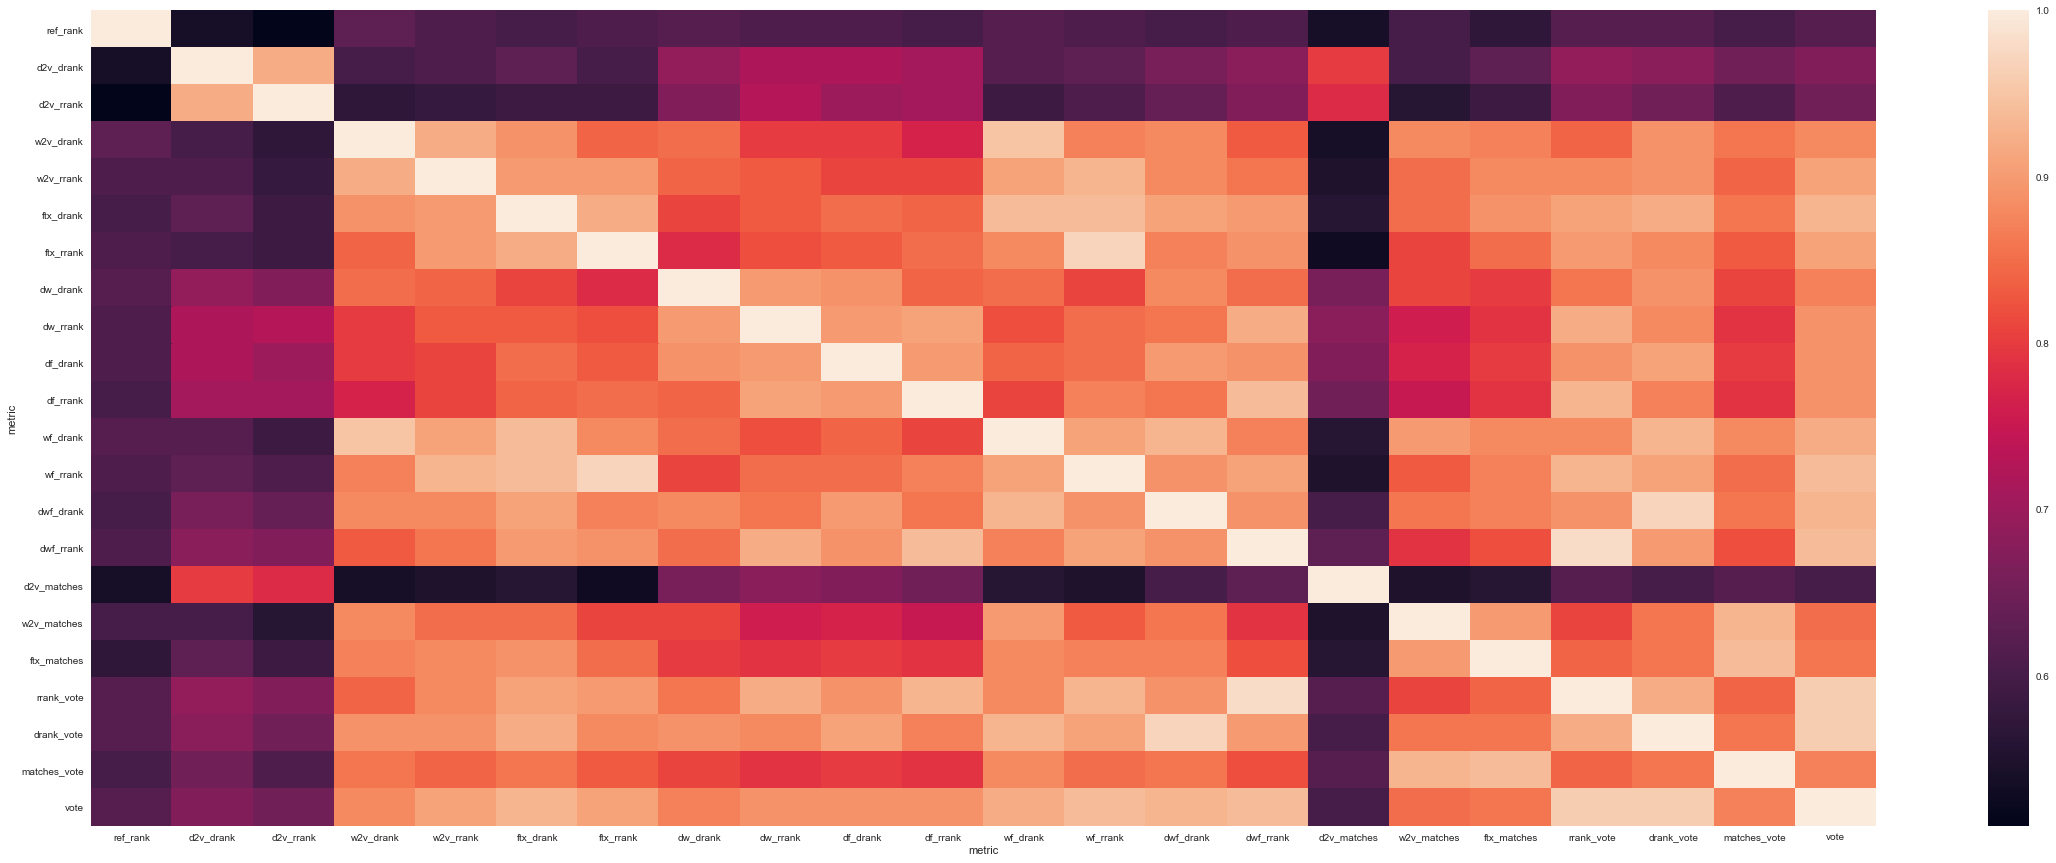

In [10]:
sns.heatmap(r)

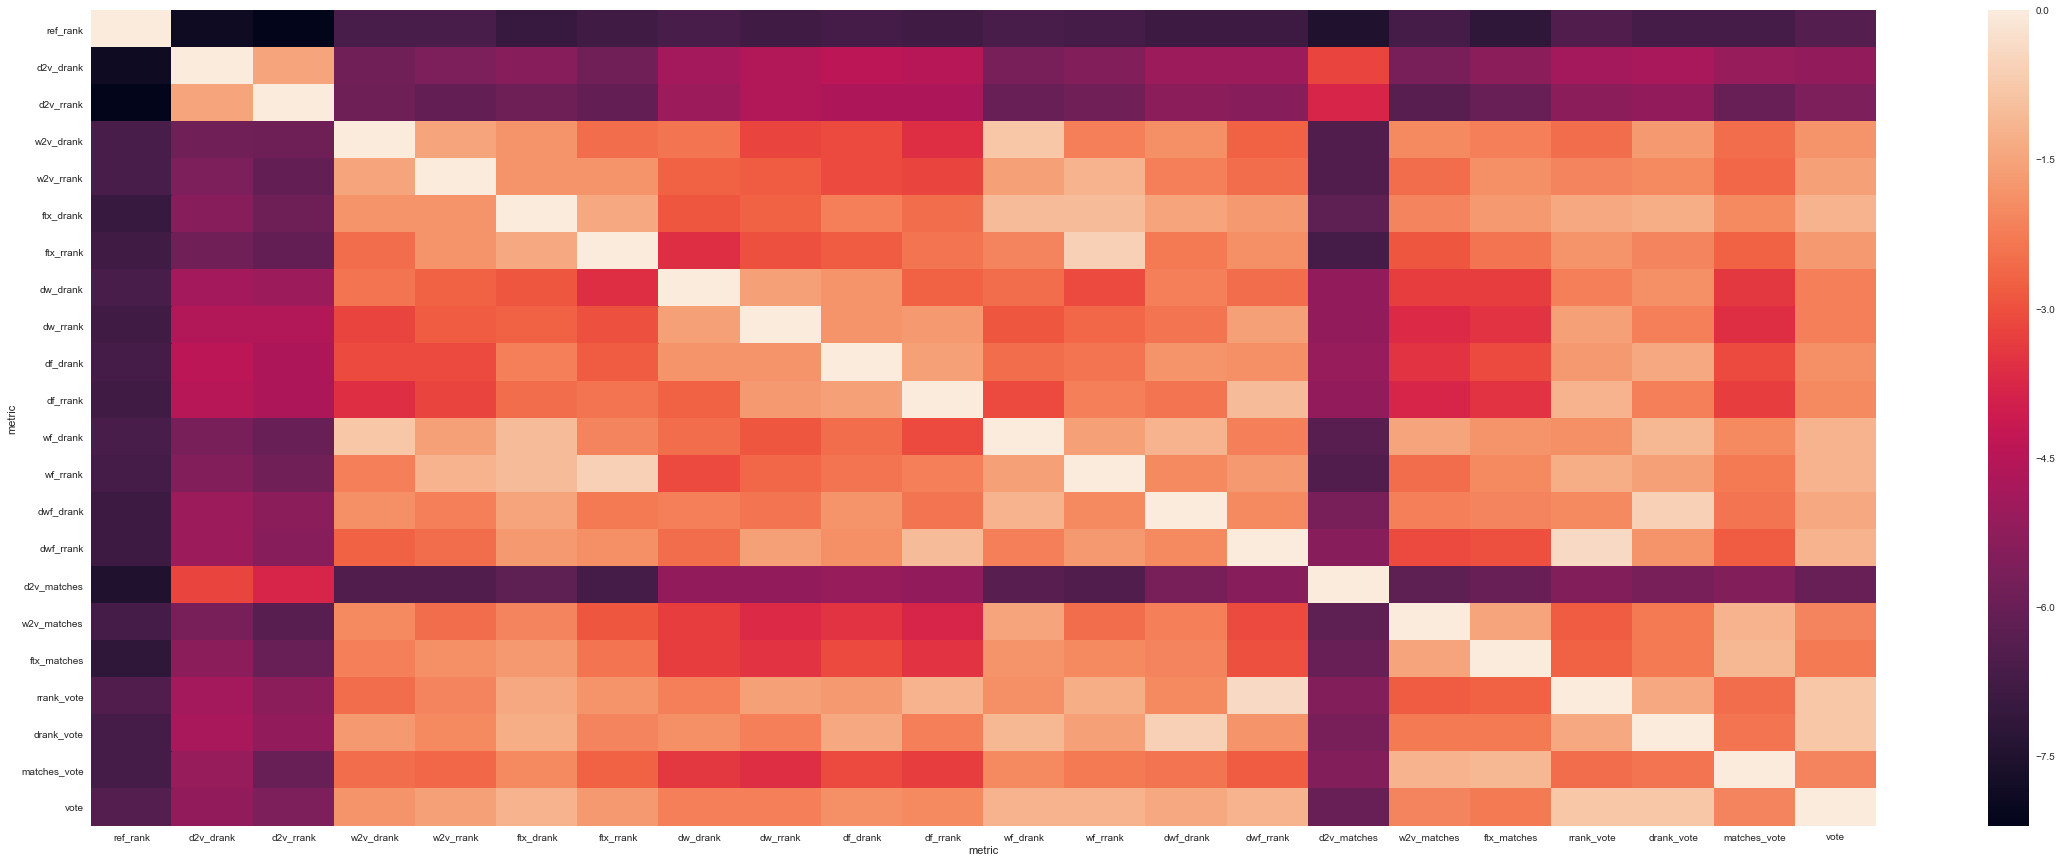

In [11]:
sns.heatmap(edit_dists * -1)